In [2]:
import utils
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np

import gym
import matplotlib.pyplot as plt

In [3]:
def learning (
    NUM_RUNS, 
    EPSILON, 
    EPSILON_DECAY, 
    REPLAY_BUFFER_SIZE, 
    REPLAY_BATCH_SIZE,
    LEARNING_RATE,
    UPDATE_FREQ):
    
    runs_results = []

    print ("START")
    env = gym.make('CartPole-v1')
    for run in range(NUM_RUNS):
        print(f"Starting run {run+1} of {NUM_RUNS}")
        policy_net = DQN([4, 128, 64, 2])
        target_net = DQN([4, 128, 64, 2])
        update_target(target_net, policy_net)
        target_net.eval()

        optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
        memory = ReplayBuffer(REPLAY_BUFFER_SIZE) # The size of the replay buffer

        steps_done = 0

        episode_durations = []
        
        epsilon = EPSILON
        
        for i_episode in range(300):            
            if (i_episode+1) % 100 == 0:
                print("episode ", i_episode+1, "/", 300) # Prints about the progress of the run
            
            observation = env.reset()
            state = torch.tensor(observation).float() # Set the initial state

            done = False
            terminated = False
            t = 0
            
            # Loop to collect data for the episode of the run and update the policies
            while not (done or terminated):
                # Select and perform an action
                action = epsilon_greedy(epsilon, policy_net, state)

                # Make an observation of the next state of the pole
                observation, reward, done, terminated = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()
                
                # Add to memory and delete the previous memory if memory full???
                memory.push([state, action, next_state, reward, torch.tensor([done])]) 

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network) if the memory is already long enough
                if not len(memory.buffer) < REPLAY_BATCH_SIZE:
                    # Sample a batch from memory
                    transitions = memory.sample(REPLAY_BATCH_SIZE) 
                    # Reshape the sample to be like a batch
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                    # Compute loss
                    mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                    
                    # Optimize the model
                    optimizer.zero_grad()                    
                    mse_loss.backward()
                    optimizer.step()
                
                # Add the episode length to the list once the episode is finished
                if done or terminated:
                    episode_durations.append(t + 1)
                    
                # Add a successfull step to the episode length 
                t += 1
                
            # Update the target network, copying all weights and biases in DQN
            if i_episode % UPDATE_FREQ == 0: 
                update_target(target_net, policy_net)
                
            epsilon = max(0.1, epsilon * EPSILON_DECAY)
                
        runs_results.append(episode_durations)
    print('Complete')
    
    return runs_results

In [4]:
def plot_results(runs_results):
# Plotting the learning curve
# Placeholder plot, you are free to modify it
    results = torch.tensor(runs_results)
    means = results.float().mean(0)
    stds = results.float().std(0)

    plt.plot(torch.arange(300), means)
    plt.ylabel("return")
    plt.xlabel("episode")
    plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
    plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
    return 0

In [22]:
def plot_results_list(runs_results_list, label_list):
# Plotting the learning curve
# Placeholder plot, you are free to modify it
    for runs_results, run_label in zip(runs_results_list, label_list) :
        results = torch.tensor(runs_results)
        means = results.float().mean(0)
        stds = results.float().std(0)

        plt.plot(torch.arange(300), means, label = run_label)
        plt.ylabel("return")
        plt.xlabel("episode")
#         plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
#         plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
        plt.legend()
        
    return 0

In [6]:
def get_results_different_E(E_LIST):
    result_list = []
    
    for E in E_LIST:
        temp_runs_results = learning (NUM_RUNS = 10, 
            EPSILON = E, 
            EPSILON_DECAY = 1, 
            REPLAY_BUFFER_SIZE = 300, 
            REPLAY_BATCH_SIZE = 1,
            LEARNING_RATE = 0.001,
            UPDATE_FREQ = 1)
        
        result_list.append(temp_runs_results)
        
    return result_list

def get_results_different_E_decaying(E_LIST):
    result_list = []
    
    for E in E_LIST:
        temp_runs_results = learning (NUM_RUNS = 2, 
            EPSILON = E, 
            EPSILON_DECAY = 0.99, 
            REPLAY_BUFFER_SIZE = 300, 
            REPLAY_BATCH_SIZE = 1,
            LEARNING_RATE = 0.001,
            UPDATE_FREQ = 1)
        
        result_list.append(temp_runs_results)
        
    return result_list

def get_results_different_E_decaying_rates(E_DECAY_RATE_LIST):
    result_list = []
    
    for E_DECAY_RATE in E_DECAY_RATE_LIST:
        temp_runs_results = learning (NUM_RUNS = 2, 
            EPSILON = 0.9, 
            EPSILON_DECAY = E_DECAY_RATE, 
            REPLAY_BUFFER_SIZE = 300, 
            REPLAY_BATCH_SIZE = 1,
            LEARNING_RATE = 0.001,
            UPDATE_FREQ = 1)
        
        result_list.append(temp_runs_results)
        
    return result_list

In [7]:
def get_results_different_update_freq(UPDATE_FREQ_LIST):
    result_list = []
    
    for FREQUENCY in UPDATE_FREQ_LIST:
        temp_runs_results = learning (NUM_RUNS = 10, 
            EPSILON = 0.9, 
            EPSILON_DECAY = 0.99, 
            REPLAY_BUFFER_SIZE = 3000, 
            REPLAY_BATCH_SIZE = 1,
            LEARNING_RATE = 0.001,
            UPDATE_FREQ = FREQUENCY)
        
        result_list.append(temp_runs_results)
        
    return result_list

In [8]:
def get_results_different_replay_buffer_size(REPLAY_BUFFER_SIZE_LIST):
    result_list = []
    
    for BUFFER_SIZE in REPLAY_BUFFER_SIZE_LIST:
        temp_runs_results = learning (NUM_RUNS = 10, 
            EPSILON = 0.9, 
            EPSILON_DECAY = 0.99, 
            REPLAY_BUFFER_SIZE = BUFFER_SIZE, 
            REPLAY_BATCH_SIZE = 1,
            LEARNING_RATE = 0.001,
            UPDATE_FREQ = 2)
        
        result_list.append(temp_runs_results)
        
    return result_list

def get_results_different_replay_batch_size(REPLAY_BATCH_SIZE_LIST):
    result_list = []
    
    for BATCH_SIZE in REPLAY_BATCH_SIZE_LIST:
        temp_runs_results = learning (NUM_RUNS = 10, 
            EPSILON = 0.9, 
            EPSILON_DECAY = 0.99, 
            REPLAY_BUFFER_SIZE = 3000, 
            REPLAY_BATCH_SIZE = BATCH_SIZE,
            LEARNING_RATE = 0.001,
            UPDATE_FREQ = 2)
        
        result_list.append(temp_runs_results)
        
    return result_list

In [9]:
def get_standard_results():
    runs_results_STANDARD = learning (NUM_RUNS = 2, 
        EPSILON = 0.9, 
        EPSILON_DECAY = 0.99, 
        REPLAY_BUFFER_SIZE = 3000, 
        REPLAY_BATCH_SIZE = 1,
        LEARNING_RATE = 0.001,
        UPDATE_FREQ = 5)
    
    return runs_results_STANDARD


START
Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 30

0

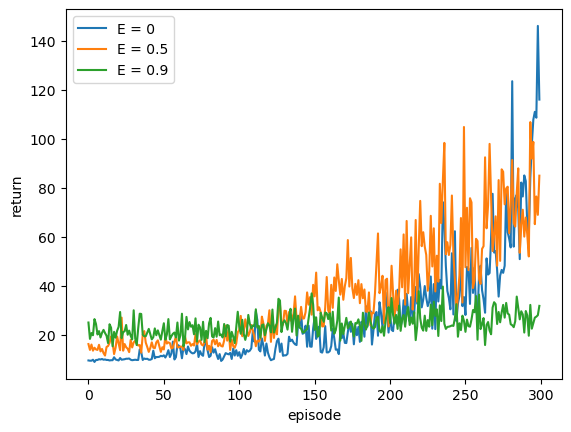

In [40]:
# GET RESULTS FOR DIFFERENT E, non decaying
E_LIST = [0, 0.5, 0.9]
# Need to adjust parameters to get less variation, or maybe just do it over more runs to get a better average
#results_E = get_results_different_E(E_LIST)
labels = ["E = " + str(E) for E in E_LIST]
plt.axhline(y = 100, color = "r", linestyle = "--")
plot_results_list(results_E, labels)

0

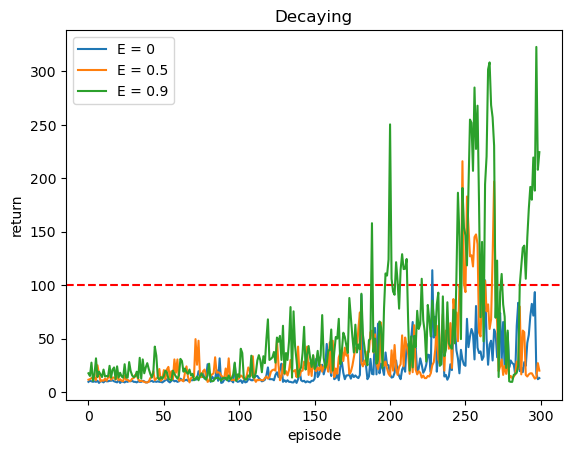

In [43]:
# GET RESULTS FOR DIFFERENT E, decaying
E_LIST = [0, 0.1, 0,3, 0.5, 0.7, 0.9, 1]
# Need to adjust parameters to get less variation, or maybe just do it over more runs to get a better average
# DECAYING E SHOWS RESULTS MORE LIKE EXPECTED, but still other hyperparameters need to be adjusted to decrease variation
results_E_decaying = get_results_different_E_decaying(E_LIST)
labels = ["E = " + str(E) for E in E_LIST]
plt.title ("Mean results over 10 runs per episode for various EPSILON (decay rate = 0.99)")
plt.axhline(y = 100, color = "r", linestyle = "--")
plot_results_list(results_E_decaying, labels)

In [ ]:
# GET RESULTS FOR DIFFERENT EPSILON DECAY RATES
E_DECAY_LIST = [1, 0.99, 0.9]

results_E_decay = get_results_different_E_decaying_rates(E_DECAY_LIST)
labels = ["E = " + str(i) for i in E_DECAY_LIST]
plt.title ("Mean results over 10 runs per episode for various Epsilon dacay rates (Epsilon = 0.9)")
plt.axhline(y = 100, color = "r", linestyle = "--")
plot_results_list(results_E_decay, labels)

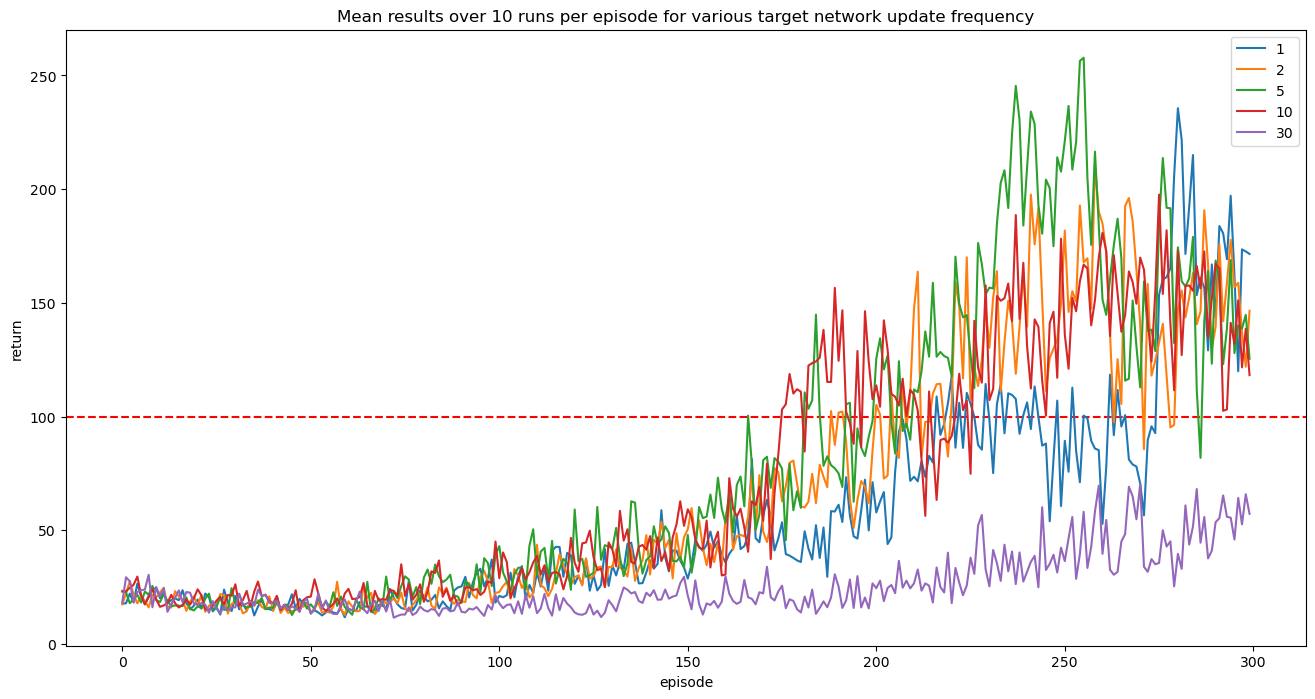

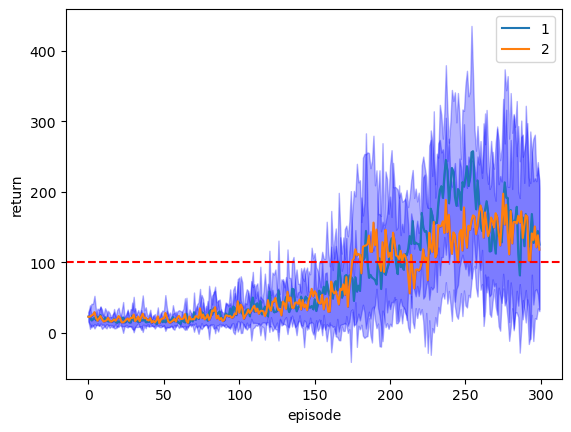

In [29]:
# GET RESULTS FOR DIFFERENT UPDATE FREQUENCIES
FREQ_LIST = [1, 2, 5, 10, 30]

# results_update_freq = get_results_different_update_freq(FREQ_LIST)
labels = ["" + str(i) for i in FREQ_LIST]
plt.figure(figsize=(16, 8))
plt.title ("Mean results over 10 runs per episode for various target network update frequency")
plt.axhline(y = 100, color = "r", linestyle = "--")
plot_results_list(results_update_freq, labels)

# I choose 5 !!!!!!!!!!!!!!!!
    
plt.figure()
plot_results(results_update_freq[2])
plot_results(results_update_freq[3])
plt.axhline(y = 100, color = "r", linestyle = "--")
plt.legend(["1", "2"])


0

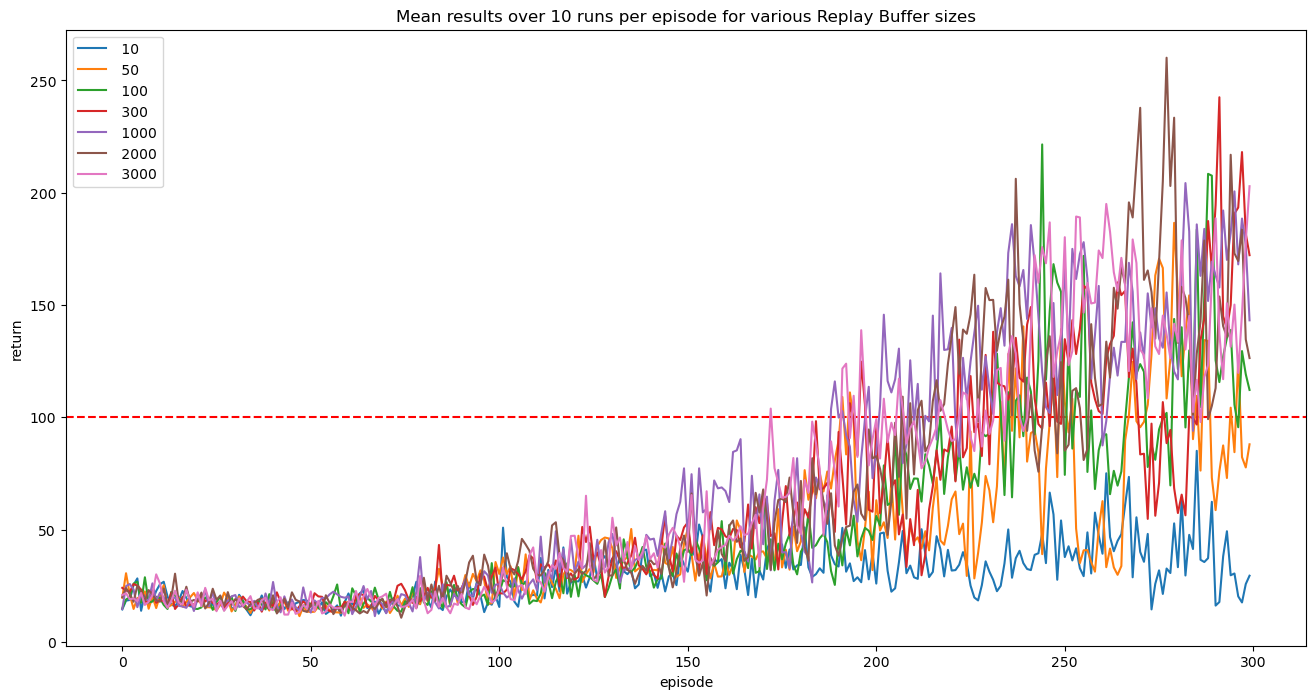

In [66]:
# GET RESULTS FOR DIFFERENT REPLAY BUFFER SIZE
BUFFER_SIZE_LIST = [10, 50, 100, 300, 1000, 2000, 3000]

# results_buffer_size = get_results_different_replay_buffer_size(BUFFER_SIZE_LIST)
labels = [" " + str(i) for i in BUFFER_SIZE_LIST]
plt.figure(figsize=(16, 8))
plt.title ("Mean results over 10 runs per episode for various Replay Buffer sizes")
plt.axhline(y = 100, color = "r", linestyle = "--")
plot_results_list(results_buffer_size, labels)

In [71]:
# open file in write mode
with open("buffersize.txt", "a") as fp:
    for item in results_buffer_size:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')
    
fp.close()

Done


In [ ]:
# GET RESULTS FOR DIFFERENT REPLAY BUFFER BATCH SIZE
BATCH_SIZE_LIST = [1, 10, 50, 100]

results_batch_size = get_results_different_replay_batch_size(BATCH_SIZE_LIST)
labels = ["" + str(i) for i in BATCH_SIZE_LIST]
plt.title ("Mean results over 10 runs per episode for various Replay Buffer batch sizes")
plt.axhline(y = 100, color = "r", linestyle = "--")
plot_results_list(results_batch_size, labels)

with open("batchsize.txt", "a") as fp:
    for item in results_batch_size:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')
    
fp.close()

In [ ]:
runs_results_STANDARD = get_standard_results()
plot_results(runs_results_STANDARD)
plt.axhline(y = 100, color = "r", linestyle = "--")
plt.show()

START
Starting run 1 of 2


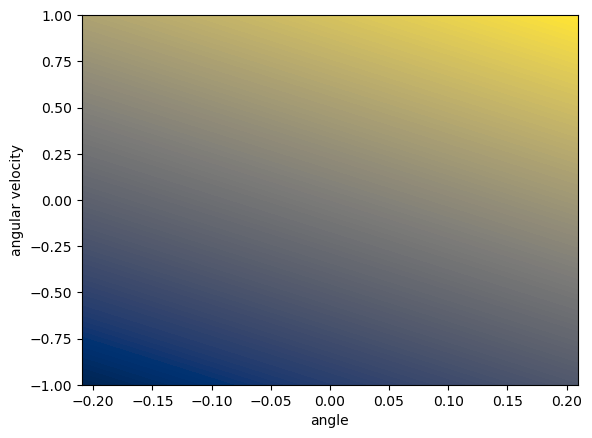

In [5]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can modify these plots

# Make sure to include appropriate labels and/or legends when presenting your plot

policy_net = DQN([4,2])   # randomly initialised, replace with your trained DQN
q = True    # whether q values or greedy policy is visualised

angle_range = .2095 # you may modify this range
omega_range = 1     # you may modify this range

angle_samples = 100
omega_samples = 100
angles = torch.linspace(angle_range, -angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)

greedy_q_array = torch.zeros((angle_samples, omega_samples))
policy_array = torch.zeros((angle_samples, omega_samples))
for i, angle in enumerate(angles):
    for j, omega in enumerate(omegas):
        state = torch.tensor([0., 0., angle, omega])
        with torch.no_grad():
            q_vals = policy_net(state)
            greedy_action = q_vals.argmax()
            greedy_q_array[i, j] = q_vals[greedy_action]
            policy_array[i, j] = greedy_action
if q:
    plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
else:
    plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
plt.xlabel("angle")
plt.ylabel("angular velocity")
plt.show()